In [88]:
import pandas as pd 
import numpy as np
import math
import json
import sys
import time
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from itertools import combinations

In [89]:
def read_file(file, for_analysis = False):
    df = pd.read_csv(file, header=None, sep=',')
    for column in df.columns:
        if int(df.at[df.index[0],column]) == 0:
            if for_analysis:
                df = df.set_axis(df[[column]].astype(str), axis=0)
            df.drop(column, axis=1, inplace=True)
    to_drop = df.index[0]
    shrunk_df = df.drop(to_drop)
    return shrunk_df

In [90]:
df = read_file("data/iris.csv")
df

,0,1,2,3
1,5.1,3.5,1.4,0.2
2,4.9,3.0,1.4,0.2
3,4.7,3.2,1.3,0.2
4,4.6,3.1,1.5,0.2
5,5.0,3.6,1.4,0.2
...,...,...,...,...
146,6.7,3.0,5.2,2.3
147,6.3,2.5,5.0,1.9
148,6.5,3.0,5.2,2.0
149,6.2,3.4,5.4,2.3


### Create Dist Matrix

In [91]:
def euclidean_dist(point, pointArray):
    return np.sqrt(np.sum((pointArray - point) ** 2, axis=1))

In [92]:
def calcDistMatrix(df, distFunctionVect):
    # must be fully numeric and normalized df
    dfarray = np.array(df)
    
    distMatrix = []
    for i, d in enumerate(dfarray):
        # performs Euclidean distance on all elements in data (vectorized)
        dists = distFunctionVect(dfarray[i], dfarray)
        distMatrix.append(dists)
    
    return pd.DataFrame(distMatrix)

In [93]:
dist_matrix = calcDistMatrix(df, euclidean_dist)
dist_matrix

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
0,0.000000,0.538516,0.509902,0.648074,0.141421,0.616441,0.519615,0.173205,0.921954,0.469042,...,5.019960,4.636809,4.208325,5.257376,5.136146,4.654031,4.276681,4.459821,4.650806,4.140048
1,0.538516,0.000000,0.300000,0.331662,0.608276,1.090871,0.509902,0.424264,0.509902,0.173205,...,5.072475,4.702127,4.180909,5.320714,5.206726,4.700000,4.249706,4.498889,4.718050,4.153312
2,0.509902,0.300000,0.000000,0.244949,0.509902,1.086278,0.264575,0.412311,0.435890,0.316228,...,5.228767,4.868265,4.334743,5.475400,5.353504,4.864155,4.430576,4.661545,4.848711,4.298837
3,0.648074,0.331662,0.244949,0.000000,0.648074,1.166190,0.331662,0.500000,0.300000,0.316228,...,5.104900,4.760252,4.177320,5.349766,5.232590,4.745524,4.288356,4.533211,4.719110,4.149699
4,0.141421,0.608276,0.509902,0.648074,0.000000,0.616441,0.458258,0.223607,0.921954,0.529150,...,5.061620,4.686150,4.246175,5.297169,5.173007,4.701064,4.330127,4.504442,4.678675,4.173727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,4.654031,4.700000,4.864155,4.745524,4.701064,4.284857,4.796874,4.598913,4.914265,4.666905,...,0.424264,0.244949,1.034408,0.734847,0.616441,0.000000,0.781025,0.360555,0.670820,0.948683
146,4.276681,4.249706,4.430576,4.288356,4.330127,3.988734,4.384062,4.200000,4.429447,4.220190,...,1.063015,0.943398,0.547723,1.307670,1.284523,0.781025,0.000000,0.583095,1.067708,0.655744
147,4.459821,4.498889,4.661545,4.533211,4.504442,4.102438,4.593474,4.397727,4.701064,4.457578,...,0.608276,0.519615,0.774597,0.842615,0.793725,0.360555,0.583095,0.000000,0.616441,0.640312
148,4.650806,4.718050,4.848711,4.719110,4.678675,4.264974,4.749737,4.589118,4.888763,4.672259,...,0.624500,0.818535,0.948683,0.806226,0.624500,0.670820,1.067708,0.616441,0.000000,0.768115


### Hcluster Setup

In [94]:
class Leaf:
    def __init__(self, data):
        self.n_type = 'leaf'
        self.height = 0
        self.data = data
        self.str_rep = str(data)

    def __repr__(self):
        return f"type: {self.n_type}, height: {self.height}, data: {self.data}"

    def to_dict(self):
        json_dict = {}
        json_dict["type"] = self.n_type
        json_dict["height"] = self.height
        json_dict["data"] = self.data
        return json_dict

class Node:
    def __init__(self, n_type, height, nodes, str_rep):
        self.n_type = n_type
        self.height = height
        self.nodes = nodes
        self.str_rep = str_rep

    def __repr__(self):
        return f"type: {self.n_type}, height: {self.height}, nodes: {self.nodes}"

    def to_dict(self):
        json_dict = {}
        json_dict["type"] = self.n_type
        json_dict["height"] = self.height
        json_dict["nodes"] = self.nodes
        return json_dict


In [95]:
def min_matrix(dist_matrix):
    min_locs = dist_matrix.idxmin()
    min_row = 0
    min_col = 0
    min_val = np.inf
    for val in min_locs:
        if dist_matrix.at[val, min_locs[val]] < min_val:
            min_col = val
            min_row = min_locs[val]
            min_val = dist_matrix.at[val, min_locs[val]]

    return min_row, min_col, min_val

In [96]:
def generate_starting_clusters(dist_matrix):
    clusters = {0:[]}
    for column in dist_matrix:
        clusters[0].append(column)
    return clusters

In [97]:
def init_dendrogram(dist_matrix):
    dgram = []
    for column in dist_matrix:
        dgram.append(Leaf(column))
    return dgram

### Hcluster (and dist funcs)

In [98]:
def single_link(s, r):
    return np.minimum(s, r)

In [99]:
def complete_link(s, r):
    return np.maximum(s, r)

In [101]:
import copy
import re
import json
def hcluster(dist_matrix, threshold = np.inf, merge_func = single_link):
    for i in range(len(dist_matrix)):
        for j in range(len(dist_matrix)):
            if i == j:
                dist_matrix.iat[i,j]=np.nan #so that 0 isn't always reported as the min val

    clusters = generate_starting_clusters(dist_matrix)
    dgram = init_dendrogram(dist_matrix)
    current_height = 0
    
    while len(clusters[current_height]) > 1:
        
        s, r, min_val = min_matrix(dist_matrix) #s = row, r = column

        # Set up next level of clusters
        clusters[current_height+1] = copy.deepcopy(clusters[current_height])
        clusters[current_height+1].remove(s)
        clusters[current_height+1].remove(r)

        # Create new cluster
        new_cluster = str((s,r)).strip()
        new_cluster = re.sub('[^A-Za-z0-9,()]+','', new_cluster)

        # Insert new cluster
        clusters[current_height+1].insert(0, new_cluster)

        a = next(item for item in dgram if item.str_rep == str(s))
        b = next(item for item in dgram if item.str_rep == str(r))
        
        dgram.append(Node('node', min_val+1, [a.to_dict(), b.to_dict()], new_cluster))
        dgram.remove(a)
        dgram.remove(b)

        
        new_matrix = pd.DataFrame(np.nan, clusters[current_height+1], clusters[current_height+1]) 
        s_values = dist_matrix.loc[s]
        r_values = dist_matrix[r]
        dist_matrix.drop(index=s, inplace=True)
        dist_matrix.drop(columns=r, inplace=True)  
        for j in clusters[current_height]:
            if j != s and j != r:
                new_matrix[j] = dist_matrix[j]
        merge = merge_func(s_values, r_values)
        merge = merge.drop(s)
        merge = merge.drop(r)
        
        new_matrix[new_cluster] = merge
        for i in merge.keys():
            new_matrix.loc[new_cluster].at[i] = merge[i]      

        dist_matrix = copy.deepcopy(new_matrix)
        current_height += 1
    dgram[0].n_type = 'root'
    dgram[0].height += min_val

    dendrogram = dgram[0].to_dict()
    f = open("dendrogram.json",'w')
    json.dump(dendrogram, f, indent = 4)

    if threshold != np.inf:
        cuts = []
        cuts = cut_dgram(dendrogram, threshold)
        return create_final_clusters(cuts)
    else:
        print("Output dendrogram to")


### Cutting dendrogram

In [102]:
def cut_dgram(dgram, threshold):
    s1 = []
    s2 = []

    s1.append(dgram)
    while len(s1) != 0:
        curr = s1.pop()
        
        if curr['height'] >= threshold:
            s1.append(curr['nodes'][0])
            s1.append(curr['nodes'][1])
        else:
            s2.append(curr)

    return s2


In [103]:
def find_leaves(dgram):
    s1 = []
    s2 = []

    s1.append(dgram)
    while len(s1) != 0:
        curr = s1.pop()
        if curr['type']=='node' or curr['type'] == 'root':
            s1.append(curr['nodes'][0])
            s1.append(curr['nodes'][1])
        else:
            s2.append(curr)
     
    # Return all the leaf data
    leaves = []
    for leaf in s2:
        leaves.append(leaf['data'])
    return leaves
        


In [104]:
def create_final_clusters(dgrams):
    cluster = 0
    clusters = {}
    for tree in dgrams:
        result = find_leaves(tree)
        clusters[cluster] = result
        cluster += 1
    return clusters


In [105]:

dist_matrix = calcDistMatrix(df, euclidean_dist)
end_gram_single = hcluster(dist_matrix, 14)
print(end_gram_single)


{0: [41, 22, 14, 15, 44, 33, 32, 16, 31, 20, 36, 13, 46, 21, 19, 6, 11, 25, 2, 47, 3, 29, 30, 37, 34, 9, 12, 1, 45, 42, 38, 8, 48, 10, 49, 39, 7, 4, 40, 0, 17, 27, 28, 35, 26, 23, 43, 24, 5, 18, 131, 117, 106, 98, 60, 93, 57, 109, 108, 134, 135, 118, 122, 105, 87, 68, 62, 114, 130, 107, 119, 100, 64, 85, 79, 73, 78, 91, 63, 61, 69, 80, 81, 89, 53, 90, 88, 94, 99, 96, 95, 92, 82, 67, 55, 66, 84, 71, 76, 77, 86, 52, 50, 97, 74, 54, 75, 65, 58, 51, 56, 59, 149, 70, 138, 127, 126, 123, 146, 113, 142, 101, 121, 133, 83, 72, 115, 136, 148, 145, 141, 103, 116, 137, 132, 128, 104, 147, 110, 111, 139, 112, 124, 143, 120, 140, 144, 102, 125, 129]}


In [106]:
dist_matrix = calcDistMatrix(df, euclidean_dist)
end_gram_comp = hcluster(dist_matrix, 14, complete_link)
print(end_gram_comp)

{0: [130, 107, 102, 125, 129, 118, 122, 105, 131, 117, 135, 109, 111, 146, 126, 123, 133, 83, 72, 134, 149, 70, 138, 127, 114, 121, 113, 142, 101, 119, 87, 68, 97, 74, 73, 78, 91, 63, 85, 51, 56, 75, 65, 76, 58, 54, 86, 52, 50, 77, 115, 147, 110, 139, 112, 145, 141, 108, 103, 116, 137, 104, 132, 128, 144, 140, 143, 120, 124, 136, 148, 100], 1: [60, 98, 93, 57, 106, 71, 61, 67, 92, 82, 99, 94, 88, 96, 95, 66, 84, 55, 90, 62, 59, 89, 53, 69, 80, 81, 64, 79, 16, 33, 32, 15, 14, 44, 46, 21, 19, 18, 5, 31, 20, 48, 10, 36, 41, 35, 25, 1, 45, 12, 37, 34, 9, 11, 29, 30, 24, 39, 7, 49, 27, 28, 0, 17, 40, 4, 43, 26, 23, 22, 6, 2, 3, 47, 42, 13, 38, 8]}


### Analysis code

In [21]:
# gets centroid of numeric dataframe (not normalized)
def calc_centroid(numdf):
    return np.divide(np.sum(np.array(numdf), axis=0),len(numdf))

In [22]:
def calc_SSE(dfarray, c, distFunc):
    return np.sum(np.square(distFunc(c, dfarray)))

In [48]:
def printClusterInfo(clusters, noData=False):
    for clusterInfo in clusters:
        for key in clusterInfo:
            if key == "dataPoints":
                if not noData:
                    print(f"{key}: \n{clusterInfo[key].to_markdown()}")
            else:
                print(f"{key}: {clusterInfo[key]}")
        print('\n')

In [49]:
def analyze_clusters(df, numdf, distFunc):
    clusters=[]
    for i, c in enumerate(df['cluster'].unique()):
        info = {}
        info["clusterID"] = i
        if c is None:
            pnts = df.loc[df['cluster'].isna()]
            info["type"] = "Noise"
        else:
            pnts = df[df['cluster'] == c]
            info["type"] = "Cluster"
        
        numpnts = numdf.loc[pnts.index]
        
        info["centroid"] = calc_centroid(numpnts)
        info["SSE"] = calc_SSE(np.array(numpnts), info["centroid"], distFunc)
        
        dists = distFunc(info["centroid"], np.array(numpnts))
        df.loc[pnts.index, "distToCentroid"] = dists
        pnts = df.loc[pnts.index]
        info["maxDistToCentroid"] = max(dists)
        info["minDistToCentroid"] = min(dists)
        info["avgDistToCentroid"] = np.sum(dists)/len(pnts)
        info["numPoints"] = len(pnts)
        info["dataPoints"] = pnts
        clusters.append(info)
    return clusters

In [132]:
def all_together(file, threshold=np.inf, dist_func=single_link, silent=False, nodata=False):
    df = read_file(file)
    dist_matrix = calcDistMatrix(df, euclidean_dist)
    end_gram = hcluster(dist_matrix, threshold, dist_func)
    dist_matrix = calcDistMatrix(df, euclidean_dist) #hcluster modifies og dist_matrix

    df = read_file(file, for_analysis=True)
    numdf = copy.deepcopy(df)

    if threshold != np.inf:
        cluster_labels=[0]*len(dist_matrix)
        for i in range(len(end_gram)):
            print(i)
            print()
            for idx in end_gram[i]:
                print(idx)
                cluster_labels[idx] = i 
        df.insert(len(df.columns), 'cluster', cluster_labels)
        #print(df)
        clusters = analyze_clusters(df, numdf, euclidean_dist)
        if silent == False:
            if nodata == True:
                printClusterInfo(clusters, noData=True)
            else:
                printClusterInfo(clusters)
        return clusters, df    

In [133]:
all_together("data/iris.csv", 3.7, complete_link)

0

130
107
102
125
129
118
122
105
131
117
135
109
1

111
146
126
123
133
83
72
134
149
70
138
127
114
121
113
142
101
119
87
68
97
74
73
78
91
63
85
51
56
75
65
76
58
54
86
52
50
77
115
147
110
139
112
145
141
108
103
116
137
104
132
128
144
140
143
120
124
136
148
100
2

60
98
93
57
106
71
61
67
92
82
99
94
88
96
95
66
84
55
90
62
59
89
53
69
80
81
64
79
3

16
33
32
15
14
44
46
21
19
18
5
31
20
48
10
36
41
35
25
1
45
12
37
34
9
11
29
30
24
39
7
49
27
28
0
17
40
4
43
26
23
22
6
2
3
47
42
13
38
8
clusterID: 0
type: Cluster
centroid: [5.006 3.418 1.464 0.244]
SSE: 762.02
maxDistToCentroid: 1.2393514432960495
minDistToCentroid: 0.059933296255086886
avgDistToCentroid: 0.48413224966894003
numPoints: 2500
dataPoints: 
|                  |   0 |   1 |   2 |   3 |   cluster |   distToCentroid |
|:-----------------|----:|----:|----:|----:|----------:|-----------------:|
| ('Iris-setosa',) | 5.1 | 3.5 | 1.4 | 0.2 |         3 |        0.146942  |
| ('Iris-setosa',) | 4.9 | 3   | 1.4 | 0.2 |     

([{'clusterID': 0,
   'type': 'Cluster',
   'centroid': array([5.006, 3.418, 1.464, 0.244]),
   'SSE': 762.02,
   'maxDistToCentroid': 1.2393514432960495,
   'minDistToCentroid': 0.059933296255086886,
   'avgDistToCentroid': 0.48413224966894003,
   'numPoints': 2500,
   'dataPoints':                   0    1    2    3  cluster  distToCentroid
   (Iris-setosa,)  5.1  3.5  1.4  0.2        3        0.146942
   (Iris-setosa,)  4.9  3.0  1.4  0.2        3        0.438169
   (Iris-setosa,)  4.7  3.2  1.3  0.2        3        0.412301
   (Iris-setosa,)  4.6  3.1  1.5  0.2        3        0.518837
   (Iris-setosa,)  5.0  3.6  1.4  0.2        3        0.197970
   ...             ...  ...  ...  ...      ...             ...
   (Iris-setosa,)  4.8  3.0  1.4  0.3        3        0.473700
   (Iris-setosa,)  5.1  3.8  1.6  0.2        3        0.418559
   (Iris-setosa,)  4.6  3.2  1.4  0.2        3        0.467324
   (Iris-setosa,)  5.3  3.7  1.5  0.2        3        0.411330
   (Iris-setosa,)  5.0  3

### Actual Commandline Running

In [27]:
import sys
threshold = 10 

sys.argv = f"hclustering.py ./data/mammal_milk.csv {threshold}".split(" ")

if __name__ == "__main__":
    if len(sys.argv) == 2:
        all_together(sys.argv[1], np.inf, complete_link)
    elif len(sys.argv) == 3:
        all_together(sys.argv[1], float(sys.argv[2]), complete_link)
    else:
        print("Usage: python3 hclustering.py <Filename> [<threshold>]")
        exit(1)
    

    

clusterID: 0
type: Cluster
centroid: [88.5    2.57   2.8    5.68   0.485]
SSE: 59.412249999999965
maxDistToCentroid: 3.4881979588320413
minDistToCentroid: 0.8765414993027995
avgDistToCentroid: 2.3077424120996444
numPoints: 10
dataPoints: 
|                |    1 |   2 |   3 |   4 |    5 |   cluster |   distToCentroid |
|:---------------|-----:|----:|----:|----:|-----:|----------:|-----------------:|
| ('Horse',)     | 90.1 | 2.6 | 1   | 6.9 | 0.35 |         2 |         2.70324  |
| ('Orangutan',) | 88.5 | 1.4 | 3.5 | 6   | 0.24 |         2 |         1.42173  |
| ('Monkey',)    | 88.4 | 2.2 | 2.7 | 6.4 | 0.18 |         2 |         0.876541 |
| ('Donkey',)    | 90.3 | 1.7 | 1.4 | 6.2 | 0.4  |         2 |         2.4969   |
| ('Hippo',)     | 90.4 | 0.6 | 4.5 | 4.4 | 0.1  |         2 |         3.4882   |
| ('Camel',)     | 87.7 | 3.5 | 3.4 | 4.8 | 0.71 |         2 |         1.6401   |
| ('Bison',)     | 86.9 | 4.8 | 1.7 | 5.7 | 0.9  |         2 |         2.98589  |
| ('Llama',)     | 86.5

### Analysis

## Mammal Milk

In [28]:
for i in range(11, 40, int((40-4)/5)):
    print(f"THRESHOLD: {i}")
    all_together('data/mammal_milk.csv', i, complete_link)

THRESHOLD: 11
clusterID: 0
type: Cluster
centroid: [88.5    2.57   2.8    5.68   0.485]
SSE: 59.412249999999965
maxDistToCentroid: 3.4881979588320413
minDistToCentroid: 0.8765414993027995
avgDistToCentroid: 2.3077424120996444
numPoints: 10
dataPoints: 
|                |    1 |   2 |   3 |   4 |    5 |   cluster |   distToCentroid |
|:---------------|-----:|----:|----:|----:|-----:|----------:|-----------------:|
| ('Horse',)     | 90.1 | 2.6 | 1   | 6.9 | 0.35 |         2 |         2.70324  |
| ('Orangutan',) | 88.5 | 1.4 | 3.5 | 6   | 0.24 |         2 |         1.42173  |
| ('Monkey',)    | 88.4 | 2.2 | 2.7 | 6.4 | 0.18 |         2 |         0.876541 |
| ('Donkey',)    | 90.3 | 1.7 | 1.4 | 6.2 | 0.4  |         2 |         2.4969   |
| ('Hippo',)     | 90.4 | 0.6 | 4.5 | 4.4 | 0.1  |         2 |         3.4882   |
| ('Camel',)     | 87.7 | 3.5 | 3.4 | 4.8 | 0.71 |         2 |         1.6401   |
| ('Bison',)     | 86.9 | 4.8 | 1.7 | 5.7 | 0.9  |         2 |         2.98589  |
| ('Llama

## 4 clusters

clusterID: 0
type: Cluster
centroid: [41.11111111 41.77777778]
SSE: 86.44444444444443
maxDistToCentroid: 4.275973645531965
minDistToCentroid: 0.7856742013183874
avgDistToCentroid: 2.9117006199139848
numPoints: 9
dataPoints: 
|    |   0 |   1 |   cluster |   distToCentroid |
|---:|----:|----:|----------:|-----------------:|
|  1 |  41 |  45 |         1 |         3.22414  |
|  2 |  39 |  44 |         1 |         3.06514  |
|  3 |  42 |  43 |         1 |         1.51127  |
|  4 |  44 |  43 |         1 |         3.1368   |
|  6 |  38 |  42 |         1 |         3.11904  |
|  8 |  41 |  41 |         1 |         0.785674 |
| 10 |  45 |  40 |         1 |         4.27597  |
| 12 |  38 |  39 |         1 |         4.17074  |
| 13 |  42 |  39 |         1 |         2.91653  |


clusterID: 1
type: Cluster
centroid: [11.91666667 37.83333333]
SSE: 390.58333333333337
maxDistToCentroid: 13.08439486139458
minDistToCentroid: 0.18633899812498061
avgDistToCentroid: 4.836295539238221
numPoints: 12
dataPoint

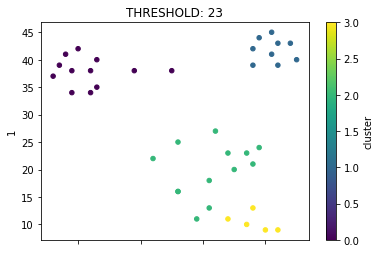

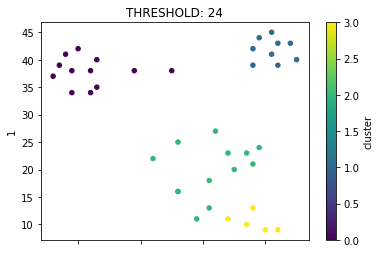

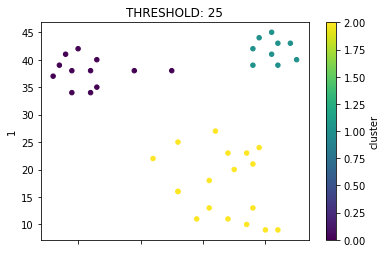

In [29]:
for i in range(23, 26):
    title = f"THRESHOLD: {i}"
    cl, mdf = all_together('data/4clusters.csv', i, complete_link, silent = False)
    mdf.plot.scatter(x=0,y=1,c='cluster',colormap='viridis', title=title)

clusterID: 0
type: Cluster
centroid: [41.11111111 41.77777778]
SSE: 86.44444444444443
maxDistToCentroid: 4.275973645531965
minDistToCentroid: 0.7856742013183874
avgDistToCentroid: 2.9117006199139848
numPoints: 9
dataPoints: 
|    |   0 |   1 |   cluster |   distToCentroid |
|---:|----:|----:|----------:|-----------------:|
|  1 |  41 |  45 |         1 |         3.22414  |
|  2 |  39 |  44 |         1 |         3.06514  |
|  3 |  42 |  43 |         1 |         1.51127  |
|  4 |  44 |  43 |         1 |         3.1368   |
|  6 |  38 |  42 |         1 |         3.11904  |
|  8 |  41 |  41 |         1 |         0.785674 |
| 10 |  45 |  40 |         1 |         4.27597  |
| 12 |  38 |  39 |         1 |         4.17074  |
| 13 |  42 |  39 |         1 |         2.91653  |


clusterID: 1
type: Cluster
centroid: [11.91666667 37.83333333]
SSE: 390.58333333333337
maxDistToCentroid: 13.08439486139458
minDistToCentroid: 0.18633899812498061
avgDistToCentroid: 4.836295539238221
numPoints: 12
dataPoint

<AxesSubplot:title={'center':'4Clusters, Threshold 23'}, xlabel='0', ylabel='1'>

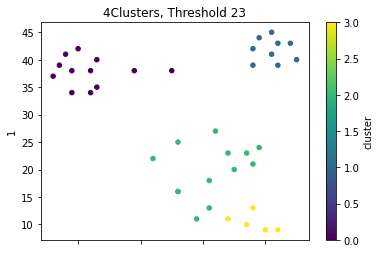

In [30]:
clusters, mdf = all_together('data/4clusters.csv', 23, complete_link, silent=False)
mdf.plot.scatter(x=0,y=1,c='cluster',colormap='viridis', title = "4Clusters, Threshold 23")

## Accidents Set 1

clusterID: 0
type: Cluster
centroid: [ 5.  14.5  1. ]
SSE: 0.5
maxDistToCentroid: 0.5
minDistToCentroid: 0.5
avgDistToCentroid: 0.5
numPoints: 2


clusterID: 1
type: Cluster
centroid: [ 5. 11.  1.]
SSE: 2.0
maxDistToCentroid: 1.0
minDistToCentroid: 0.0
avgDistToCentroid: 0.6666666666666666
numPoints: 3


clusterID: 2
type: Cluster
centroid: [5.  8.2 1. ]
SSE: 2.8000000000000003
maxDistToCentroid: 1.1999999999999993
minDistToCentroid: 0.1999999999999993
avgDistToCentroid: 0.6399999999999999
numPoints: 5


clusterID: 3
type: Cluster
centroid: [ 2. 19.  2.]
SSE: 0.0
maxDistToCentroid: 0.0
minDistToCentroid: 0.0
avgDistToCentroid: 0.0
numPoints: 1


clusterID: 4
type: Cluster
centroid: [2.  2.5 1.5]
SSE: 9.000000000000002
maxDistToCentroid: 1.5811388300841898
minDistToCentroid: 0.7071067811865476
avgDistToCentroid: 1.1441228056353687
numPoints: 6


clusterID: 5
type: Cluster
centroid: [2.  5.  3.5]
SSE: 0.5
maxDistToCentroid: 0.5
minDistToCentroid: 0.5
avgDistToCentroid: 0.5
numPoints: 2



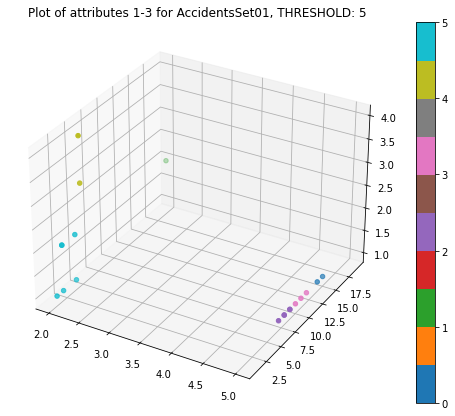

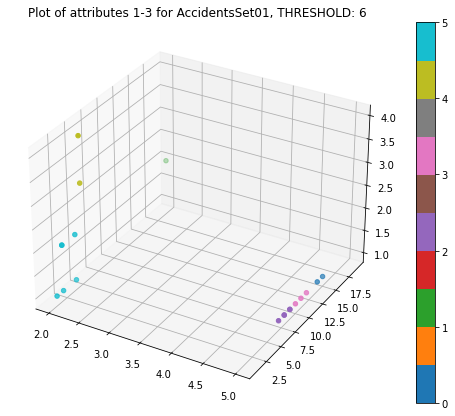

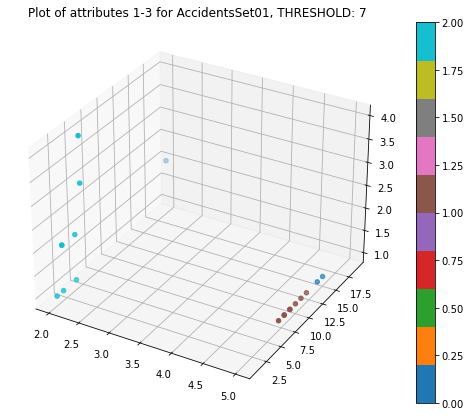

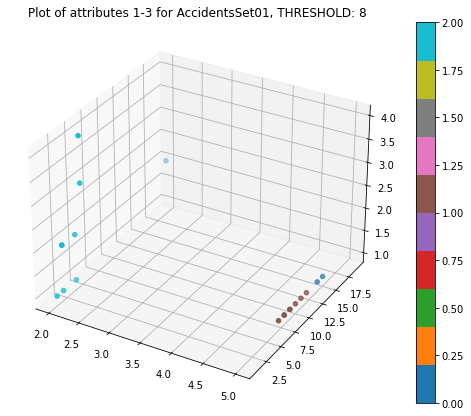

In [79]:
for i in range(5, 9, 1):
    title = f"THRESHOLD: {i}"
    cl, df = all_together('data/AccidentsSet01.csv', i, complete_link, silent=False, nodata=True)
    print(df)
    fig = plt.figure(figsize = (10, 7))
    ax = plt.axes(projection ="3d")
    cb = ax.scatter3D(df[0], df[1], df[2], c=df['cluster'], cmap='tab10')
    plt.colorbar(cb)
    plt.title(f"Plot of attributes 1-3 for AccidentsSet01, " + title)

clusterID: 0
type: Cluster
centroid: [ 4.         16.          1.33333333]
SSE: 20.666666666666664
maxDistToCentroid: 3.6666666666666665
minDistToCentroid: 1.4529663145135578
avgDistToCentroid: 2.460136547407327
numPoints: 3
dataPoints: 
|    |   0 |   1 |   2 |   cluster |   distToCentroid |
|---:|----:|----:|----:|----------:|-----------------:|
|  1 |   5 |  15 |   1 |         0 |          1.45297 |
|  2 |   5 |  14 |   1 |         0 |          2.26078 |
| 11 |   2 |  19 |   2 |         0 |          3.66667 |


clusterID: 1
type: Cluster
centroid: [5.   9.25 1.  ]
SSE: 19.5
maxDistToCentroid: 2.75
minDistToCentroid: 0.25
avgDistToCentroid: 1.3125
numPoints: 8
dataPoints: 
|    |   0 |   1 |   2 |   cluster |   distToCentroid |
|---:|----:|----:|----:|----------:|-----------------:|
|  3 |   5 |  12 |   1 |         1 |             2.75 |
|  4 |   5 |  11 |   1 |         1 |             1.75 |
|  5 |   5 |  10 |   1 |         1 |             0.75 |
|  6 |   5 |   9 |   1 |         1 |

Text(0.5, 0.92, 'Plot of attributes 1-3 for AccidentsSet01, THRESHOLD: 7')

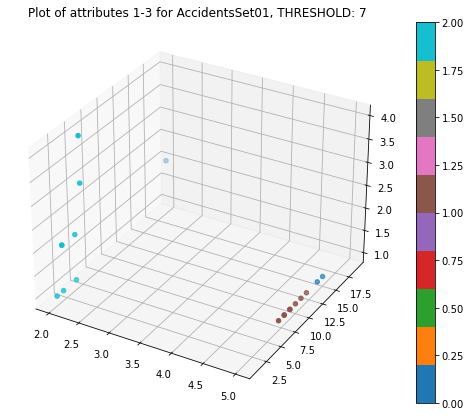

In [67]:
    i = 7
    title = f"THRESHOLD: {i}"
    cl, df = all_together('data/AccidentsSet01.csv', i, complete_link, silent=False, nodata=False)

    fig = plt.figure(figsize = (10, 7))
    ax = plt.axes(projection ="3d")
    cb = ax.scatter3D(df[0], df[1], df[2], c=df['cluster'], cmap='tab10')
    plt.colorbar(cb)
    plt.title(f"Plot of attributes 1-3 for AccidentsSet01, " + title)

## Accidents Set 3

In [85]:
i=5
title = f"THRESHOLD: {i}"
all_together('data/AccidentsSet03.csv', i, complete_link, silent=False, nodata=False)

clusterID: 0
type: Cluster
centroid: [3.46666667 0.13333333 3.2        1.         0.46666667]
SSE: 29.600000000000005
maxDistToCentroid: 1.8147543451754933
minDistToCentroid: 1.0456258094238746
avgDistToCentroid: 1.3742091576007391
numPoints: 15


clusterID: 1
type: Cluster
centroid: [1.15151515 0.48484848 2.72727273 1.12121212 0.54545455]
SSE: 58.727272727272734
maxDistToCentroid: 1.9170109883557225
minDistToCentroid: 1.0041237288352054
avgDistToCentroid: 1.3015294296567537
numPoints: 33


clusterID: 2
type: Cluster
centroid: [10.  0.  4.  1.  1.]
SSE: 0.0
maxDistToCentroid: 0.0
minDistToCentroid: 0.0
avgDistToCentroid: 0.0
numPoints: 1


clusterID: 3
type: Cluster
centroid: [1.         1.         4.         1.15384615 1.38461538]
SSE: 10.769230769230772
maxDistToCentroid: 2.649103901188087
minDistToCentroid: 0.41424344670265406
avgDistToCentroid: 0.6792429633163727
numPoints: 13




([{'clusterID': 0,
   'type': 'Cluster',
   'centroid': array([3.46666667, 0.13333333, 3.2       , 1.        , 0.46666667]),
   'SSE': 29.600000000000005,
   'maxDistToCentroid': 1.8147543451754933,
   'minDistToCentroid': 1.0456258094238746,
   'avgDistToCentroid': 1.3742091576007391,
   'numPoints': 15,
   'dataPoints':       0    1    2    3    4  cluster  distToCentroid
   1   3.0  0.0  2.0  1.0  0.0        1        1.375984
   2   5.0  0.0  4.0  1.0  1.0        1        1.814754
   3   5.0  0.0  4.0  1.0  0.0        1        1.796292
   5   3.0  0.0  2.0  1.0  1.0        1        1.400000
   6   4.0  0.0  4.0  1.0  0.0        1        1.077033
   8   4.0  0.0  2.0  1.0  0.0        1        1.400000
   10  3.0  1.0  2.0  1.0  0.0        1        1.620699
   11  3.0  1.0  2.0  1.0  1.0        1        1.641138
   12  4.0  0.0  2.0  1.0  0.0        1        1.400000
   14  3.0  0.0  4.0  1.0  1.0        1        1.077033
   15  3.0  0.0  4.0  1.0  0.0        1        1.045626
   18  

      0    1    2    3    4
1   3.0  0.0  2.0  1.0  0.0
2   5.0  0.0  4.0  1.0  1.0
3   5.0  0.0  4.0  1.0  0.0
4   2.0  0.0  2.0  1.0  0.0
5   3.0  0.0  2.0  1.0  1.0
..  ...  ...  ...  ...  ...
58  1.0  1.0  4.0  1.0  0.0
59  1.0  1.0  4.0  1.0  0.0
60  1.0  1.0  4.0  1.0  1.0
61  1.0  1.0  4.0  1.0  0.0
62  1.0  1.0  4.0  1.0  1.0

[62 rows x 5 columns]


array([[<AxesSubplot:xlabel='0', ylabel='0'>,
        <AxesSubplot:xlabel='1', ylabel='0'>,
        <AxesSubplot:xlabel='2', ylabel='0'>,
        <AxesSubplot:xlabel='3', ylabel='0'>,
        <AxesSubplot:xlabel='4', ylabel='0'>],
       [<AxesSubplot:xlabel='0', ylabel='1'>,
        <AxesSubplot:xlabel='1', ylabel='1'>,
        <AxesSubplot:xlabel='2', ylabel='1'>,
        <AxesSubplot:xlabel='3', ylabel='1'>,
        <AxesSubplot:xlabel='4', ylabel='1'>],
       [<AxesSubplot:xlabel='0', ylabel='2'>,
        <AxesSubplot:xlabel='1', ylabel='2'>,
        <AxesSubplot:xlabel='2', ylabel='2'>,
        <AxesSubplot:xlabel='3', ylabel='2'>,
        <AxesSubplot:xlabel='4', ylabel='2'>],
       [<AxesSubplot:xlabel='0', ylabel='3'>,
        <AxesSubplot:xlabel='1', ylabel='3'>,
        <AxesSubplot:xlabel='2', ylabel='3'>,
        <AxesSubplot:xlabel='3', ylabel='3'>,
        <AxesSubplot:xlabel='4', ylabel='3'>],
       [<AxesSubplot:xlabel='0', ylabel='4'>,
        <AxesSubplot:xlabel='1

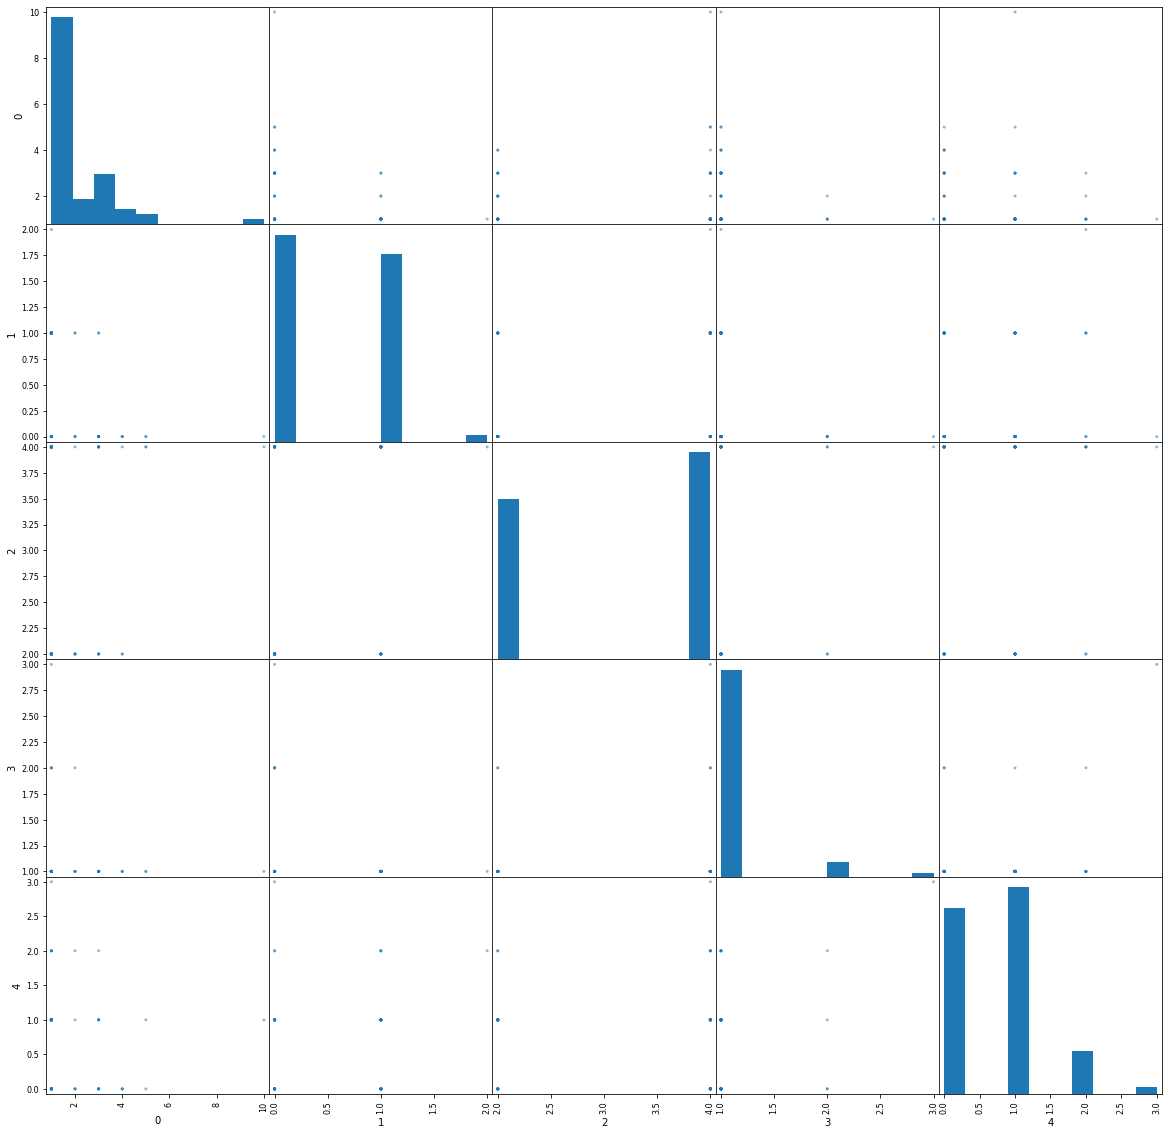

In [82]:
cl, df = all_together('data/AccidentsSet03.csv', 3, complete_link, silent=True, nodata=True)
test = df.drop('distToCentroid', axis=1)
test = test.drop('cluster', axis=1)
#print(test)
#pd.plotting.scatter_matrix(test, alpha=0.5, figsize=(20, 20))

## Iris

In [119]:
    cd, mdf = all_together('data/iris.csv', 3.5, complete_link)

{0: [130, 107, 102, 125, 129, 118, 122, 105, 131, 117, 135, 109], 1: [111, 146, 126, 123, 133, 83, 72, 134, 149, 70, 138, 127, 114, 121, 113, 142, 101, 119, 87, 68, 97, 74, 73, 78, 91, 63, 85, 51, 56, 75, 65, 76, 58, 54, 86, 52, 50, 77, 115, 147, 110, 139, 112, 145, 141, 108, 103, 116, 137, 104, 132, 128, 144, 140, 143, 120, 124, 136, 148, 100], 2: [60, 98, 93, 57, 106, 71, 61, 67, 92, 82, 99, 94, 88, 96, 95, 66, 84, 55, 90, 62, 59, 89, 53, 69, 80, 81, 64, 79], 3: [16, 33, 32, 15, 14, 44, 46, 21, 19, 18, 5, 31, 20, 48, 10, 36, 41, 35, 25, 1, 45, 12, 37, 34, 9, 11, 29, 30, 24, 39, 7, 49, 27, 28, 0, 17, 40, 4, 43, 26, 23, 22, 6, 2, 3, 47, 42, 13, 38, 8]}
clusterID: 0
type: Cluster
centroid: [5.006 3.418 1.464 0.244]
SSE: 762.02
maxDistToCentroid: 1.2393514432960495
minDistToCentroid: 0.059933296255086886
avgDistToCentroid: 0.48413224966894003
numPoints: 2500
dataPoints: 
|                  |   0 |   1 |   2 |   3 |   cluster |   distToCentroid |
|:-----------------|----:|----:|----:|----

## Many Clusters

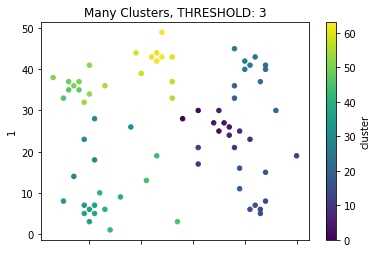

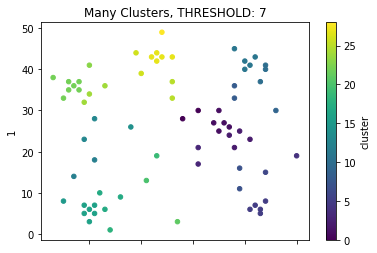

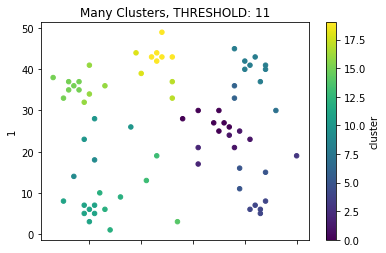

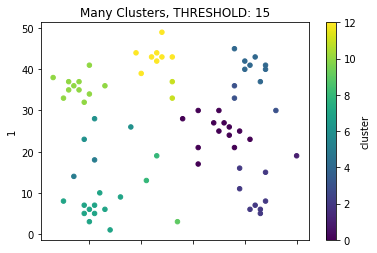

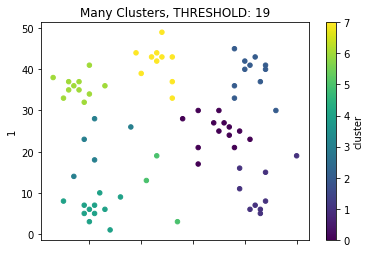

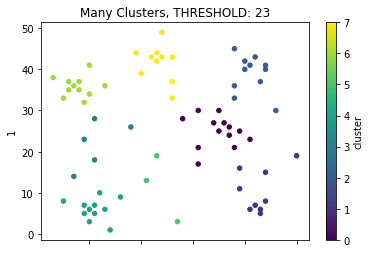

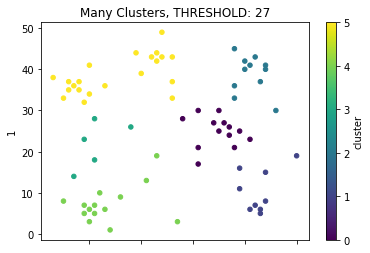

In [39]:
for i in range(3, 30, int((51-3)/10)):
    title=f"THRESHOLD: {i}"
    cl, mdf = all_together('data/many_clusters.csv', i, complete_link, silent=True)
    mdf.plot.scatter(x=0,y=1,c='cluster',colormap='viridis', title = "Many Clusters, " + title)

clusterID: 0
type: Cluster
centroid: [23.3 41.7]
SSE: 228.2
maxDistToCentroid: 9.109335870413389
minDistToCentroid: 0.424264068711927
avgDistToCentroid: 4.005879958716356
numPoints: 10
dataPoints: 
|    |   0 |   1 |   cluster |   distToCentroid |
|---:|----:|----:|----------:|-----------------:|
|  1 |  24 |  49 |         7 |         7.33348  |
|  3 |  19 |  44 |         7 |         4.87647  |
|  4 |  23 |  44 |         7 |         2.31948  |
|  5 |  22 |  43 |         7 |         1.83848  |
|  6 |  24 |  43 |         7 |         1.47648  |
|  7 |  26 |  43 |         7 |         2.99666  |
|  9 |  23 |  42 |         7 |         0.424264 |
| 16 |  20 |  39 |         7 |         4.2638   |
| 20 |  26 |  37 |         7 |         5.42033  |
| 29 |  26 |  33 |         7 |         9.10934  |


clusterID: 1
type: Cluster
centroid: [41.27272727 38.90909091]
SSE: 277.09090909090907
maxDistToCentroid: 10.08558418062448
minDistToCentroid: 1.676280810416891
avgDistToCentroid: 4.396794888519616
nu

<AxesSubplot:title={'center':'Many Clusters, THRESHOLD: 23'}, xlabel='0', ylabel='1'>

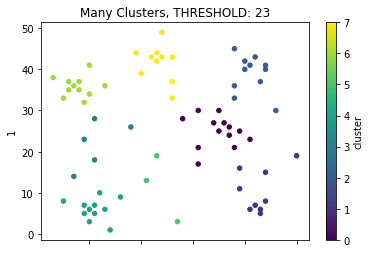

In [43]:
    i = 23
    title=f"THRESHOLD: {i}"
    cl, mdf = all_together('data/many_clusters.csv', i, complete_link, silent=False)
    mdf.plot.scatter(x=0,y=1,c='cluster',colormap='viridis', title = "Many Clusters, " + title)